In [1]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, accuracy_score, \
    classification_report, precision_recall_curve, roc_curve, auc, average_precision_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split, cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

import warnings
warnings.filterwarnings("ignore")

# Read dataset
df = pd.read_csv('input/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


* As all the V features are PCA transformed, We can be sure that these features are already scaled.
* But if we observe, the remaining columns like Amount and Time, they are not scaled. So lets perform 
scaling on these features too.
* As RobustScaler is less prone to outliers, we can use that.

In [2]:
robust_scaler = RobustScaler()
df['Amount'] = robust_scaler.fit_transform(df[['Amount']])
df['Time'] = robust_scaler.fit_transform(df[['Time']])

Now lets look at the value counts to check how imbalance data sets are

In [3]:
# Now lets look at the value counts to check how imbalance data sets are
print(df['Class'].value_counts(normalize=True))
# So we can see that the data is heavily skewed.
# We have 99.8% Non-fraud data and only 0.0017 percent of Fraud data
print(df['Class'].value_counts())
# So we have only 492 fraud samples
# Lets check if we have any missing values
print(df.isnull().sum())
# As we can see that no missing values in the data.
# Now lets check the types of each column
print(df.info())
# So we can see that every column is a numeric column.

0    0.998273
1    0.001727
Name: Class, dtype: float64
0    284315
1       492
Name: Class, dtype: int64
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-nul

* We should not touch the test data as we want to make those samples unseen
* So now the train data becomes the actual dataset.

In [4]:
y_final = df['Class']
X_final = df.drop(['Class'], axis=1)
print('Shape before test train split', df.shape)

X_final_train, X_final_test, y_final_train, y_final_test = train_test_split(X_final, y_final, test_size=0.20, random_state=100, stratify=y_final)

df = pd.concat([X_final_train, y_final_train], axis=1)
df.reset_index(drop=True, inplace=True)
print('Train dataset shape after test train split', df.shape)
print('Test dataset shape after test train split', X_final_test.shape)

Shape before test train split (284807, 31)
Train dataset shape after test train split (227845, 31)
Test dataset shape after test train split (56962, 30)


### All definitions/methods to run machine different machine learning models on any given dataset split

In [5]:
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
k_near_params = {"n_neighbors": list(range(2, 5, 1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2, 6, 1)), "min_samples_leaf": list(range(5, 8, 1))}

classifiers = {
    "LogisiticRegression": (LogisticRegression(), log_reg_params),
    "KNearest": (KNeighborsClassifier(), k_near_params),
    "Support Vector Classifier": (SVC(), svc_params),
    "DecisionTreeClassifier": (DecisionTreeClassifier(), tree_params),
    "Naive Bayes": (GaussianNB(), None),
    "Random forests": (RandomForestClassifier(), tree_params)
}

def get_best_model(model, params, X, y):
    model = GridSearchCV(model, params)
    model.fit(X, y)
    return model.best_estimator_


def run_all_models(X, y, choose_best_model=True, folds=5):
    for classifier_name, (classifier, params) in classifiers.items():
        k_fold = StratifiedKFold(n_splits=folds, random_state=100, shuffle=True)
        cross_val_scores = []
        precision_scores = []
        recall_scores = []
        roc_auc_scores = []
        f1_scores = []
        estimators = []
        for train_index, test_index in k_fold.split(X, y):
            X_train, X_test = pd.DataFrame(data=X, index=train_index), pd.DataFrame(data=X, index=test_index)
            y_train, y_test = pd.DataFrame(data=y, index=train_index), pd.DataFrame(data=y, index=test_index)
            if params is None or not choose_best_model:
                model = classifier
                model.fit(X_train, y_train)
            else:
                model = get_best_model(classifier, params, X_train, y_train)
            estimators.append(model)
            scores = cross_val_score(model, X_train, y_train.values.ravel(), cv=5)
            cross_val_scores.append(scores)
            y_pred = model.predict(X_test)
            precision_scores.append(precision_score(y_test, y_pred))
            recall_scores.append(recall_score(y_test, y_pred))
            roc_auc_scores.append(roc_auc_score(y_test, y_pred))
            f1_scores.append(f1_score(y_test, y_pred))

        print('============================= {} ============================='.format(classifier_name))
        print('Mean cross validation score: {}'.format(np.array([cross_val_scores]).mean()))
        print('Mean precision score: {}'.format(np.array([precision_scores]).mean()))
        print('Mean Recall score: {}'.format(np.array([recall_scores]).mean()))
        print('Mean ROC-AUC score: {}'.format(np.array([roc_auc_scores]).mean()))
        print('Mean F1 score: {}'.format(np.array([f1_scores]).mean()))
        best_iteration = recall_scores.index(max(recall_scores))
        best_estimator = estimators[best_iteration]
        print('Best estimator: {}'.format(estimators[best_iteration]))
        print('******* Real test dataset metrics *******')
        y_final_pred = best_estimator.predict(X_final_test)
        print('Accuracy score for the real test set:\n', accuracy_score(y_final_test, y_final_pred))
        print('confusion matrix for the real test set:\n', confusion_matrix(y_final_test, y_final_pred))
        print('Classification report for the real test set:\n', classification_report(y_final_test, y_final_pred))
        if classifier_name != 'Support Vector Classifier':
            y_final_pred_prob =best_estimator.predict_proba(X_final_test)
            plot_auc_roc_curve(y_final_test, y_final_pred_prob[:, 1], classifier_name)
            plot_precision_recall_curve(y_final_test, y_final_pred_prob[:, 1], classifier_name)

### All definitions/methods used for plotting

In [6]:
def plot_clustering(X):
    # Lets plot the data on 2 dimensional plane to see if our model predicts good going forward.

    # Otherwise it takes lot of time.
    # PCA Dimensionality reduction
    pca = PCA(n_components=2, random_state=100)
    pca_components = pca.fit_transform(X.values)
    plt.scatter(pca_components[:, 0], pca_components[:, 1], c=(y == 0), label='No Fraud')
    plt.scatter(pca_components[:, 0], pca_components[:, 1], c=(y == 1), label='Fraud')
    plt.show()

    # T-SNE clustering
    tsne = TSNE(n_components=2, random_state=100)
    tsne_components = tsne.fit_transform(X.values)
    plt.scatter(tsne_components[:, 0], tsne_components[:, 1], c=(y == 0), label='No Fraud')
    plt.scatter(tsne_components[:, 0], tsne_components[:, 1], c=(y == 1), label='Fraud')
    plt.show()


def plot_precision_recall_curve(y_test, y_pred_prob, name):
    # Generate precision recall curve values: precision, recall, thresholds
    precision, recall, thresholds = precision_recall_curve(y_test.to_numpy(), y_pred_prob)

    # Plot Precion Recall curve
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    avg_precision_score = average_precision_score(y_test, y_pred_prob)
    plt.title('PRC for {} - avg precision score: {}'.format(name, str(avg_precision_score)))
    plt.show()


def plot_auc_roc_curve(y_test, y_pred, name):
    fpr, tpr, thresholds = roc_curve(y_test.to_numpy(), y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC
    plt.title('ROC for {}'.format(name))
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.0])
    plt.ylim([-0.1, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
df_fraud = df[df['Class'] == 1]
df_no_fraud = df[df['Class'] == 0]

#### To handle data imbalance we will follow the following strategies.
1. Random Under Sampling
2. Oversampling using SMOTE
3. Hybrid sampling

### Random Under Sampling

Random under sampling
1    394
0    394
Name: Class, dtype: int64


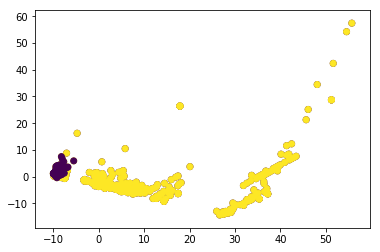

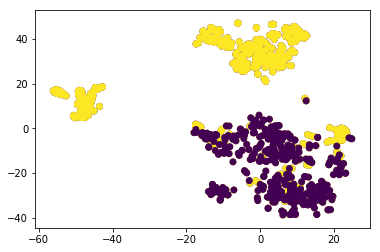

============================= Random forests =============================
Mean cross validation score: 0.9336706349206348
Mean precision score: 0.9752642868097239
Mean Recall score: 0.8857189224277832
Mean ROC-AUC score: 0.931418370658877
Mean F1 score: 0.9276578128291864
Best estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
******* Real test dataset metrics *******
Accuracy score for the real test set:
 0.9632562058916471
confusion matrix for the real test set:
 [[54785  2079]
 [   14    84]]
Classification report for the real test set:
               precision    recall  f1-score   support

           0    

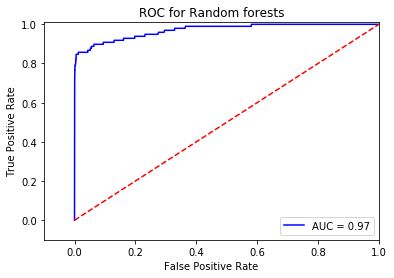

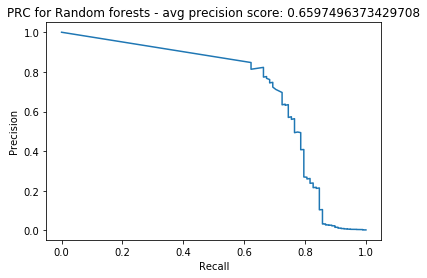

============================= LogisiticRegression =============================
Mean cross validation score: 0.9431944444444443
Mean precision score: 0.962536363309729
Mean Recall score: 0.913664394677053
Mean ROC-AUC score: 0.9390619928594612
Mean F1 score: 0.9372799534983063
Best estimator: LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
******* Real test dataset metrics *******
Accuracy score for the real test set:
 0.9774937677750078
confusion matrix for the real test set:
 [[55596  1268]
 [   14    84]]
Classification report for the real test set:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.86      0.12        98

   micro avg       0.98      0.98      0.98     56962
   mac

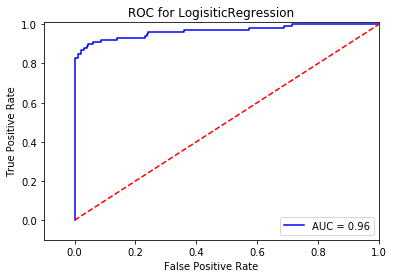

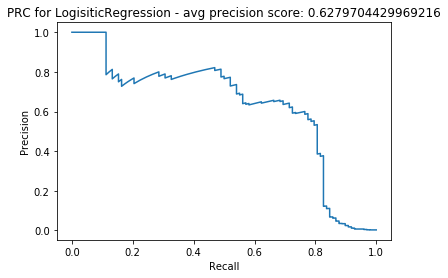

============================= Naive Bayes =============================
Mean cross validation score: 0.922564484126984
Mean precision score: 0.9717300497620863
Mean Recall score: 0.8730606945796818
Mean ROC-AUC score: 0.9238396624472575
Mean F1 score: 0.9193500639739195
Best estimator: GaussianNB(priors=None, var_smoothing=1e-09)
******* Real test dataset metrics *******
Accuracy score for the real test set:
 0.9651170956075981
confusion matrix for the real test set:
 [[54893  1971]
 [   16    82]]
Classification report for the real test set:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.04      0.84      0.08        98

   micro avg       0.97      0.97      0.97     56962
   macro avg       0.52      0.90      0.53     56962
weighted avg       1.00      0.97      0.98     56962



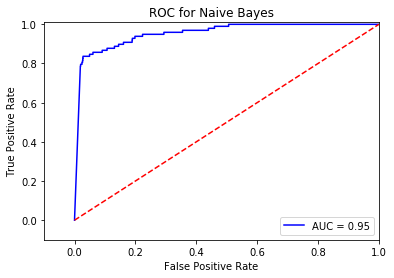

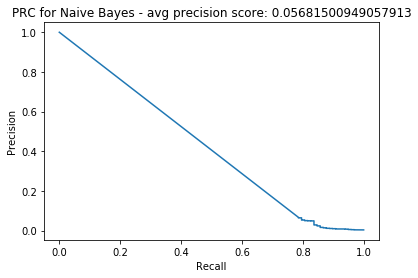

============================= DecisionTreeClassifier =============================
Mean cross validation score: 0.9206597222222221
Mean precision score: 0.9592079893449755
Mean Recall score: 0.8857189224277832
Mean ROC-AUC score: 0.9238234339500163
Mean F1 score: 0.9207428982212369
Best estimator: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
******* Real test dataset metrics *******
Accuracy score for the real test set:
 0.9584986482216215
confusion matrix for the real test set:
 [[54512  2352]
 [   12    86]]
Classification report for the real test set:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04    

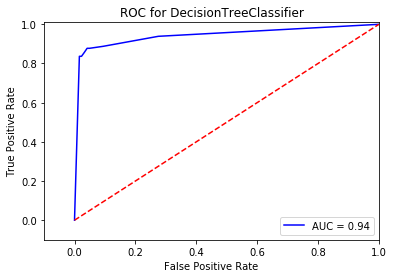

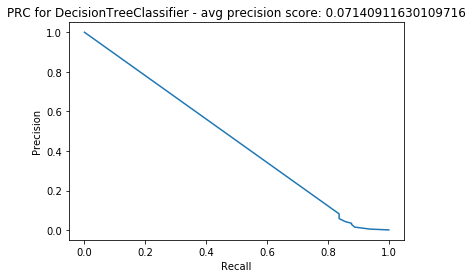

============================= KNearest =============================
Mean cross validation score: 0.9377926587301587
Mean precision score: 0.9646931989197436
Mean Recall score: 0.8959104186952288
Mean ROC-AUC score: 0.9314508276533594
Mean F1 score: 0.9287708296285146
Best estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')
******* Real test dataset metrics *******
Accuracy score for the real test set:
 0.9823566588251817
confusion matrix for the real test set:
 [[55875   989]
 [   16    82]]
Classification report for the real test set:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.08      0.84      0.14        98

   micro avg       0.98      0.98      0.98     56962
   macro avg       0.54      0.91      0.57     56962
weighted avg       1.00      0.98      0.99     56962



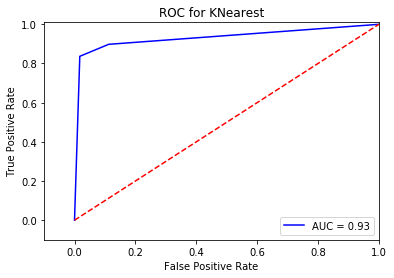

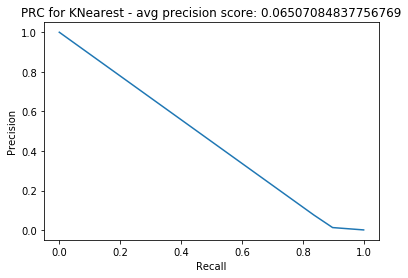

============================= Support Vector Classifier =============================
Mean cross validation score: 0.9368601190476188
Mean precision score: 0.9634094368340943
Mean Recall score: 0.9060694579681922
Mean ROC-AUC score: 0.935280753002272
Mean F1 score: 0.9335353632652634
Best estimator: SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
******* Real test dataset metrics *******
Accuracy score for the real test set:
 0.9898177732523437
confusion matrix for the real test set:
 [[56299   565]
 [   15    83]]
Classification report for the real test set:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.13      0.85      0.22        98

   micro avg       0.99      0.99      0.99     56962
   macro avg       0.56   

In [11]:
# ==================== Random Under sampling using sklearn resample ====================
print('Random under sampling')

# Lets first split the X into fraud and no_fraud subsets
df_fraud = df[df['Class'] == 1]
df_no_fraud = df[df['Class'] == 0]
df_no_fraud_under_sampled = resample(df_no_fraud, n_samples=len(df_fraud), replace=False, random_state=100)
df_under_sampled = pd.concat([df_fraud, df_no_fraud_under_sampled])
print(df_under_sampled['Class'].value_counts())
# So we can see that the data got balanced after we brought down the majority class.
del df_no_fraud_under_sampled

y = df_under_sampled['Class']
X = df_under_sampled.drop(['Class'], axis=1)

X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

plot_clustering(X)
run_all_models(X, y)

### Under Sampling using Near Miss algorithm

Under sampling using Nearmiss algorithm
1    394
0    394
Name: Class, dtype: int64
============================= Random forests =============================
Mean cross validation score: 0.9145386904761904
Mean precision score: 0.983434877147206
Mean Recall score: 0.8832197338526452
Mean ROC-AUC score: 0.9339824732229796
Mean F1 score: 0.9299683068243543
Best estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
******* Real test dataset metrics *******
Accuracy score for the real test set:
 0.9861662160738738
confusion matrix for the real test set:
 [[56090   774]
 [   14    84]]
Classification report for the 

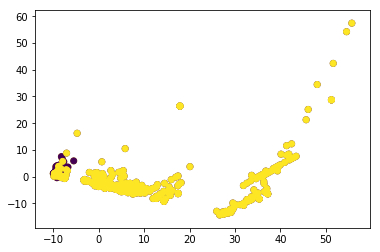

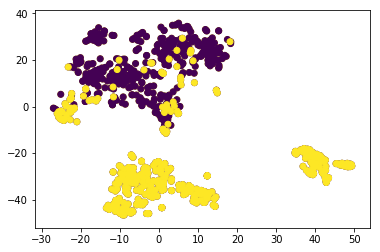

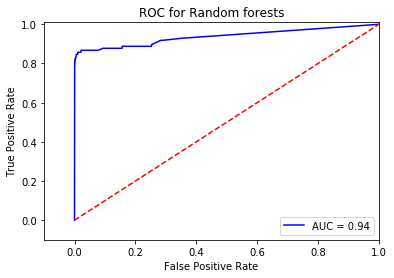

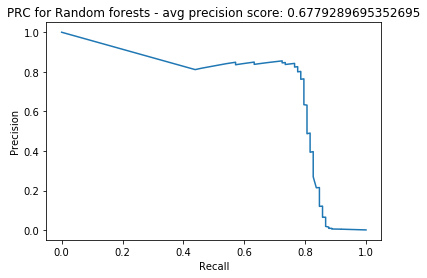

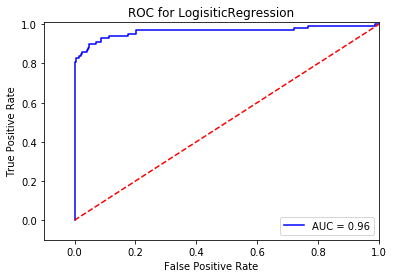

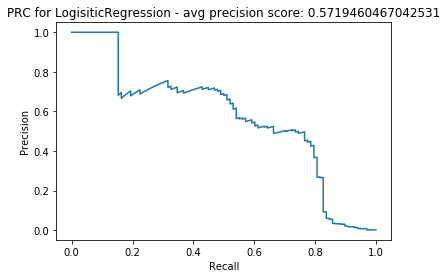

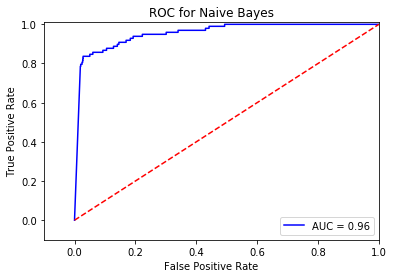

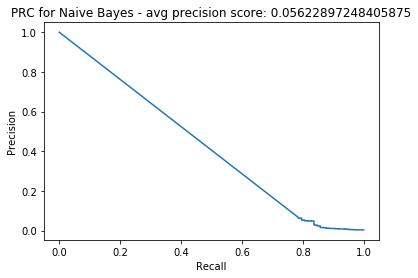

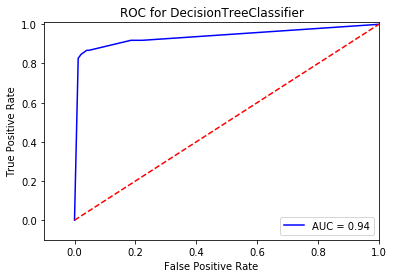

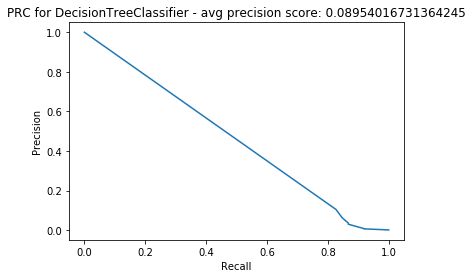

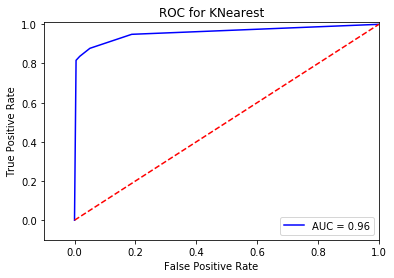

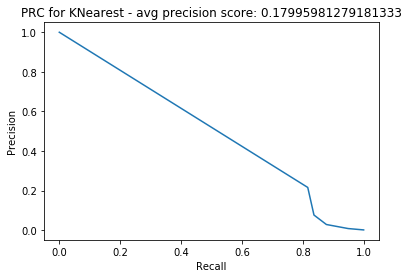

In [8]:
# ====================  Under sampling using Nearmiss algorithm ====================
print('Under sampling using Nearmiss algorithm')

X_under_sampled, y_under_sampled = NearMiss().fit_resample(X, y)
df_X_under_sampled = pd.DataFrame(X_under_sampled, columns=X.columns)
df_y_under_sampled = pd.DataFrame(y_under_sampled, columns=['Class'])

df_near_miss_under_sampled = pd.concat([df_X_under_sampled, df_y_under_sampled], axis=1)
print(df_y_under_sampled['Class'].value_counts())
del df_X_under_sampled, df_y_under_sampled

y = df_near_miss_under_sampled['Class']
X = df_near_miss_under_sampled.drop(['Class'], axis=1)

X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

plot_clustering(X)
run_all_models(X, y)

### Random Over sampling technique

Random over sampling
1    227451
0    227451
Name: Class, dtype: int64
============================= Random forests =============================
Mean cross validation score: 0.9999444934311387
Mean precision score: 0.9998988961714439
Mean Recall score: 1.0
Mean ROC-AUC score: 0.9999494394372391
Mean F1 score: 0.9999494437618848
Best estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
******* Real test dataset metrics *******
Accuracy score for the real test set:
 0.9995435553526912
confusion matrix for the real test set:
 [[56860     4]
 [   22    76]]
Classification report for the real test set:
            

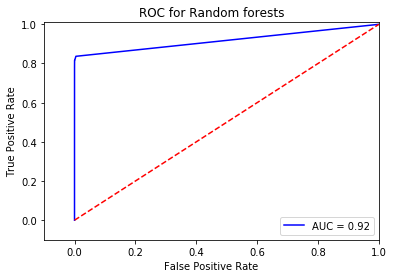

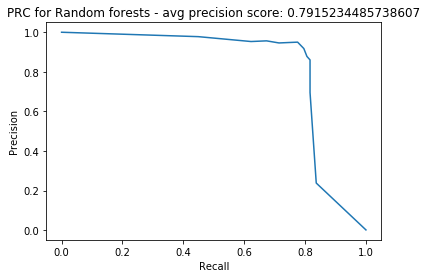

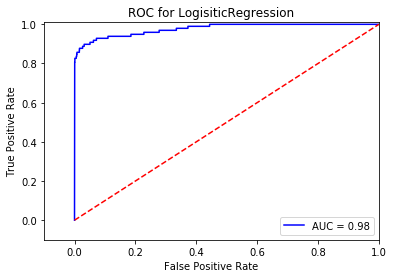

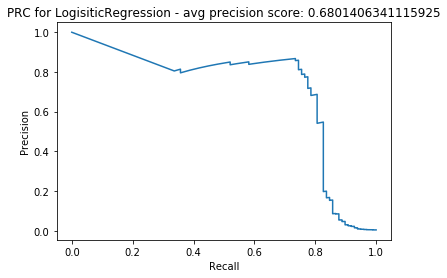

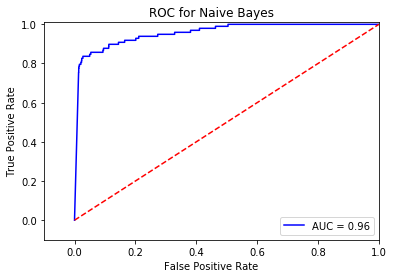

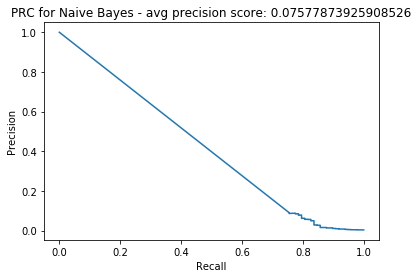

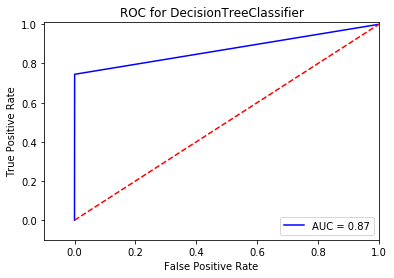

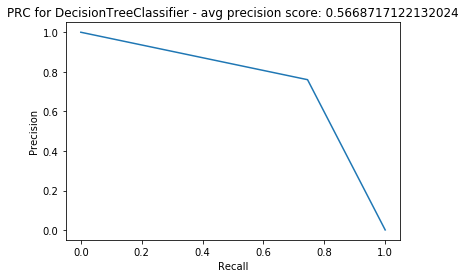

KeyboardInterrupt: 

In [9]:
# ====================  Random Over sampling technique ====================

print('Random over sampling')
df_fraud_over_sampled = df_fraud.sample(len(df_no_fraud), replace=True)

df_random_over_sampled = pd.concat([df_no_fraud, df_fraud_over_sampled])
print(df_random_over_sampled['Class'].value_counts())

y = df_random_over_sampled['Class']
X = df_random_over_sampled.drop(['Class'], axis=1)

X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

run_all_models(X, y, choose_best_model=False)

### Over sampling using SMOTE algorithm

Random over sampling using SMOTE
1    227451
0    227451
Name: Class, dtype: int64
============================= Random forests =============================
Mean cross validation score: 0.9998483188402525
Mean precision score: 0.9998329553422728
Mean Recall score: 0.9999516379158704
Mean ROC-AUC score: 0.9998922842600833
Mean F1 score: 0.9998922920155184
Best estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
******* Real test dataset metrics *******
Accuracy score for the real test set:
 0.9995259997893332
confusion matrix for the real test set:
 [[56854    10]
 [   17    81]]
Classification report for the 

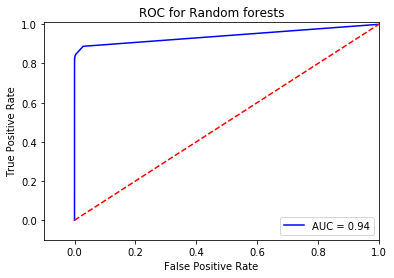

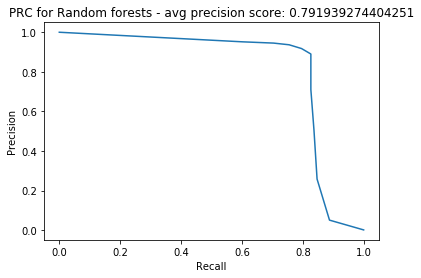

============================= LogisiticRegression =============================
Mean cross validation score: 0.9527639980287251
Mean precision score: 0.9769011596053524
Mean Recall score: 0.9274700947347372
Mean ROC-AUC score: 0.9527700470263735
Mean F1 score: 0.9515435156714178
Best estimator: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
******* Real test dataset metrics *******
Accuracy score for the real test set:
 0.978792879463502
confusion matrix for the real test set:
 [[55668  1196]
 [   12    86]]
Classification report for the real test set:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.88      0.12        98

   micro avg       0.98      0.98      0.98     56962
   ma

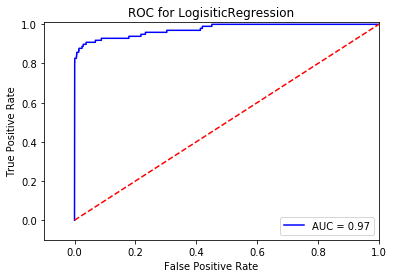

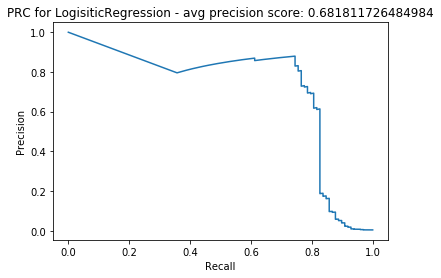

============================= Naive Bayes =============================
Mean cross validation score: 0.9178971473706558
Mean precision score: 0.9718761616518256
Mean Recall score: 0.8606161299306235
Mean ROC-AUC score: 0.9178548324577829
Mean F1 score: 0.9128673159519834
Best estimator: GaussianNB(priors=None, var_smoothing=1e-09)
******* Real test dataset metrics *******
Accuracy score for the real test set:
 0.9743864330606369
confusion matrix for the real test set:
 [[55422  1442]
 [   17    81]]
Classification report for the real test set:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.83      0.10        98

   micro avg       0.97      0.97      0.97     56962
   macro avg       0.53      0.90      0.54     56962
weighted avg       1.00      0.97      0.99     56962



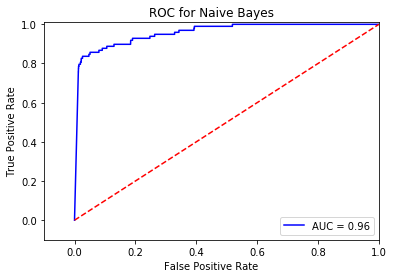

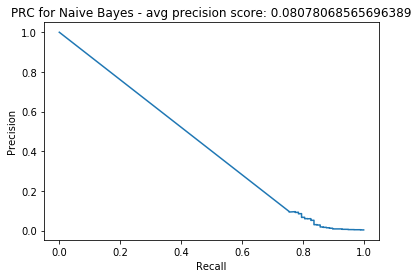

KeyboardInterrupt: 

In [12]:
# ====================  Over sampling using SMOTE algorithm ====================
print('Random over sampling using SMOTE')
y = df['Class']
X = df.drop(['Class'], axis=1)
smote = SMOTE(sampling_strategy='minority')
X_smote, y_smote = smote.fit_resample(X, y)
df_X_smote = pd.DataFrame(X_smote, columns=X.columns)
df_y_smote = pd.DataFrame(y_smote, columns=['Class'])

df_smote = pd.concat([df_X_smote, df_y_smote], axis=1)
print(df_smote['Class'].value_counts())
del df_X_smote, df_y_smote

y = df_smote['Class']
X = df_smote.drop(['Class'], axis=1)

X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

run_all_models(X, y, choose_best_model=False)

### Over sampling using Hybrid algorithm

Hybrid sampling
1    113922
0    113922
Name: Class, dtype: int64
============================= Random forests =============================
Mean cross validation score: 0.9999166089165504
Mean precision score: 0.999868355999957
Mean Recall score: 1.0
Mean ROC-AUC score: 0.9999341647111001
Mean F1 score: 0.9999341713562936
Best estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
******* Real test dataset metrics *******
Accuracy score for the real test set:
 0.9995259997893332
confusion matrix for the real test set:
 [[56858     6]
 [   21    77]]
Classification report for the real test set:
               pre

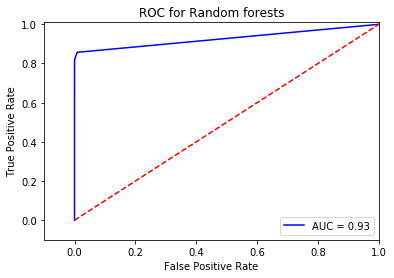

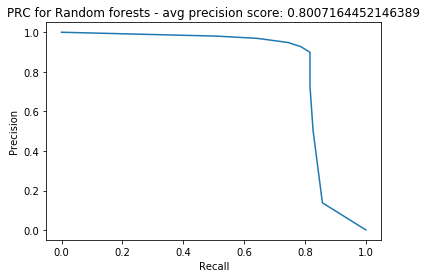

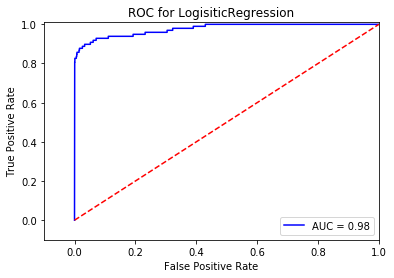

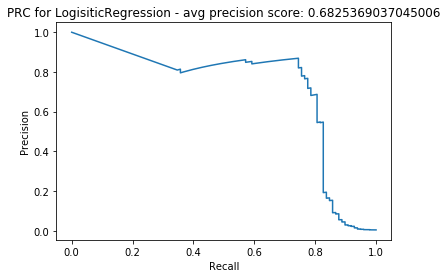

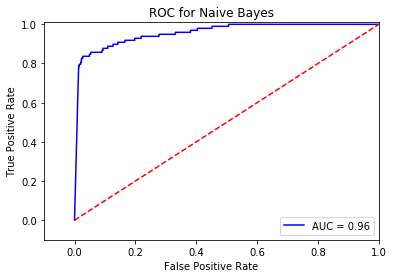

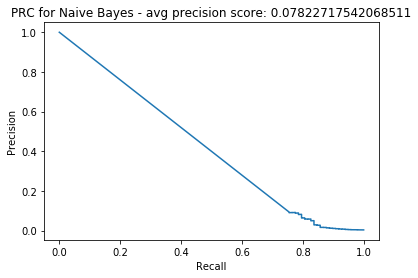

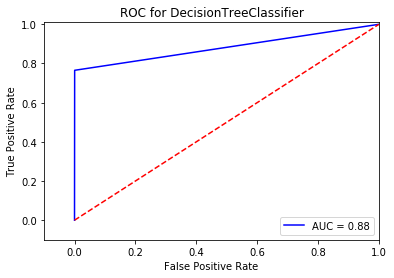

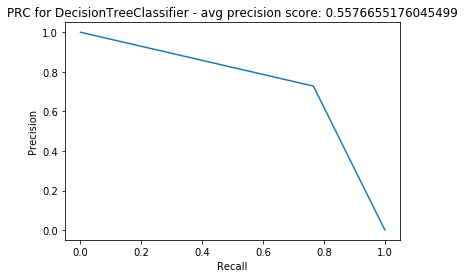

In [ ]:
print('Hybrid sampling')
y = df['Class']
X = df.drop(['Class'], axis=1)
samples = X.shape[0]
df_fraud_over_sampled = df_fraud.sample(int(samples/2), replace=True)
df_fraud_under_sampled = df_no_fraud.sample(int(samples/2), replace=False)

df_hybrid = pd.concat([df_fraud_over_sampled, df_fraud_under_sampled])
print(df_hybrid['Class'].value_counts())

y = df_hybrid['Class']
X = df_hybrid.drop(['Class'], axis=1)

X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

run_all_models(X, y, choose_best_model=False)